# Solução numérica da equação de Burgers Viscosa via redes neurais guiadas pela Física (PINNs)

## Introdução

Este notebook tem como referência os seguintes trabalhos:

- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations*. [arXiv 1711.10561](https://arxiv.org/abs/1711.10561) <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)
- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations*. [arXiv 1711.10566](https://arxiv.org/abs/1711.10566)
- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*. J. Comp. Phys. 378 pp. 686-707 [DOI: 10.1016/j.jcp.2018.10.045](https://www.sciencedirect.com/science/article/pii/S0021999118307125)
- [Códigos do GitHub de Jan Blechschmidt](https://github.com/janblechschmidt/PDEsByNNs), pós-doc da [TU Chemnitz](https://www.tu-chemnitz.de/index.html.en).
- Jan Blechschmidt, Oliver G. Ernst. *Three Ways to Solve Partial Differential Equations with Neural Networks -- A Review*. [arXiv 2102.11802](https://arxiv.org/abs/2102.11802)


---


<a name="cite_note-1"></a>[[1]](#cite_ref-1) Nesse artigo, está disponível o código do github de Maziar Raissi (página 4). (appendix -> continuous_time_inference (Burgers) -> Burgers.py). Porém, foi implementado na versão 1.X do TersorFlow, o que hoje em dia não funciona mais, mesmo assim, dá pra ter uma ideia geral da maneira que o código foi construído e planejado. Para mais informações de código, veja o GitHub e o artigo de Jan Blechschmidt


---

O texto a seguir está organizado da seguinte forma:

1. [Descrição da Equação de Burgers Viscosa](#p1)
2. [Modelagem computacional](#p2)
3. [Implementação numérica](#p3)





<a name="p1"></a>
## 1 Descrição da Equação de Burgers Viscosa


A Equação Diferencial Parcial que trataremos consiste em determinar $u = u(x,t)$ solução de:

> Aqui a notação de subscrito representa a derivada parcial

> função $u_0(x)$ é a solução inicial em $t=0$

$$
\begin{aligned}
    u_t + u \, u_x - \nu \, u_{xx} &= 0, \quad &&\quad (x,t) \in  (-1,1) \times (0,1) \\
   u(x,0) &= u_0(x),                 \quad &&\quad x \in (-1,1),\\
   u(-1,t) = u(1,t) &= 0,                      \quad &&\quad t \in (0,1),
\end{aligned}
$$

onde $\nu$ é a viscosidade. Esta EDP surge em diferentes contextos, por exemplo, tráfego de carros, dinâmica dos fluidos.

<a name="p2"></a>
## 2 Modelagem computacional

O tratamento numérico da Equação de Burgers Viscosa será feito por meio de uma formulação computacional que consiste em transformar o problema de valor inicial e de fronteira em um problema de otimização.

Mais especificamente, vamos determinar uma função $u(x,t)$ que resolve simultaneamente os seguintes problemas de otimização:

1. Problema 1 - Operador Diferencial: $$
\min |f(x,t)| \quad \text{ s.a. } \quad (x,t) \in  (-1,1) \times (0,1),
$$
onde
$$
f:= u_t + uu_x - \nu u_{xx}.
$$

2. Problema 2 - Condição Inicial (tempo $t=0$): $$
\min |u(x,0) - u_0(x)| \quad \text{ s.a. } \quad x \in  (-1,1).
$$

3. Problema 3 - Condição de Fronteira/Bordo: $$
\min |u(-1,t)| + |u(1,t)| \quad \text{ s.a. } \quad t \in  (0,1).
$$

A função $u(x,t)$ será aproximada via Redes Neurais por meio da minimização do Erro Médio Quadrático (EMQ) da função de perda.

Neste contexto os Problemas 1, 2 e 3 acima são reescritos da seguinte forma:

1. $$
\text{EMQ}_f = \cfrac{1}{N_f}\sum_{i = 1}^{N_f} \left| f(x_i, t_i) \right|^2,
$$
onde $(x_i, t_i)$, $i = 1, \cdots, N_f$, representa $N_f$ pontos de colocação escolhidos aleatoriamente em $(-1,1) \times (0,1)$.

2. $$
\text{EMQ}_0 = \cfrac{1}{N_0}\sum_{i=1}^{N_0} \left| (u(x_i,0) - u_0(x_i)\right|^2,
$$
onde $x_i$, $i = 1, \cdots, N_0$ representa $N_0$ pontos de colocação no intervalo $(-1,1)$;

3. $$
\text{EMQ}_b = \cfrac{1}{N_b}\sum_{i=1}^{N_b} \left| u(x_i,t_i) \right|^2,
$$
onde $(x_i,t_i)$, $i = 1, \cdots, N_b$ corresponde à $N_b$ pontos de colocação ao longo do conjunto cartesiano $\{-1,1\} \times (0,1)$.

Por fim, minimizamos a função de perda:
$$
\text{EMQ} = \text{EMQ}_f + \text{EMQ}_0 + \text{EMQ}_b
$$

<a name="p3"></a>
## 3 Implementação numérica

A implementação se baseia na biblioteca [NumPy](https://numpy.org/doc/stable/user/whatisnumpy.html) e na biblioteca de ML [TensorFlow](https://www.tensorflow.org/).

E seguirá os seguintes passos abaixo:
1.    [Importação dos pacotes necessários e definição dos dados específicos do problema](#p31)
2.    [Geração dos pontos de colocação (Criação do conjunto de treino)](#p32)
3.    [Configuração da rede neural](#p33)
4.    [Configuração das rotinas para derivação automática (automatic differentiation) e para função de perda](#p34)
5.    [Treinamento da rede](#p35)
6.    [Visualização da solução](#p36)

<a name="p31"></a>
### 3.1. Importação dos pacotes necessários e definição dos dados específicos do problema

Esse código é executado com a versão `2.15.0` do TensorFlow.

> Começamos a implementar esse código na versão `2.12`

In [ ]:
import numpy as np  # Biblioteca NumPy clássica do Python
from numpy import linalg as LA  # Importar função de Algebra Linear no NumPy, para realização do erro relativo futuramente
import matplotlib.pyplot as plt  # Biblioteca para visualização e criação de gráficos
import plotly.graph_objects as go  # Biblioteca para a visualização do gráfico 3D da EDP
from mpl_toolkits.mplot3d import Axes3D  # Biblioteca para a visualização do gráfico 3D da EDP
import warnings
warnings.filterwarnings('ignore')  # Biblioteca warnings para ignorar avisos diminuindo a poluição visual
import tensorflow as tf  # Bibliteca TensorFlow para criação da rede neural
from time import time   # função para calculo do tempo computacional, utilização equivalente ao tic toc
import scipy.io   # para importar e exportar aquirvos .mat

# define a semente aleatória para reproduzir os resultados
import os
import random
seed_value = 0
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)

np.random.seed(seed_value)  # caso o numpy nao esteja fixado, a função de bernoulli irá retornar diferentes valores
tf.random.set_seed(seed_value)  # esta função "fixa" os dados amostrados

print(tf.__version__)  # impressão da versão do tf utilizado (código criado na versão 2.X)

2.17.0


#### 3.1.1 Definição dos parâmetros do problema

In [ ]:
# Definir o tipo de dado do tensorflow,
# garante que todos os cálculos sejam realizados usando números de ponto flutuante de 32 bits.

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)
'''
outra opção seria o float64, com 2x a precisão do float32, porém com muito mais
armazenamento de memória e mais demorado. Com o float32 ocupamos menos espaço e
ainda assim, realizando cálculos eficientes e rápidos. Um possível teste para o futuro seria
trocar para float64 e comparar os resultados.
'''

# Definição da viscosidade
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = 0.01/pi

# Definição da condição inicial (x precisa ser um tensor)
def u_0(x):
    return -tf.sin(pi * x)

'''
No TensorFlow, os tensores são a principal forma de representar dados
e operações.
Tensor é uma estrutura de dados flexível e multidimensional, pode ser escalar,
vetor, matriz ...  usada no TensorFlow para representar e manipular dados
durante o treinamento e a inferência de modelos de aprendizado de máquina.
'''

'''
Definição da condição de fronteira.
No nosso problema, u(x,t) := u_b(x,t) = 0, onde (x,t) \in {-1,1} X (0,1), ou seja
u(-1,t) = u(1,t) = 0.
'''

def u_b(x, t):
    n = x.shape[0]  # Retorna o número de linhas do vetor/tensor x
    return tf.zeros((n,1), dtype=DTYPE)  # Retorna um tensor de zeros do tamanho (n,1)

# Definição da função f(x,t) (operador diferencial)
def f(u, u_x, u_t, u_xx):
    return u_t + u * u_x - viscosity * u_xx

<a name="p32"></a>
### 3.2. Gerar um conjunto de pontos de colocação (Criação do conjunto de treino)

Relembre que para resolver os problemas de otimização 1, 2 e 3, precisamos dos seguintes pontos de colocação:

1. O operador diferencial $f(x,t)$ avaliado em $(x_i,t_i) \in (-1,1) \times (0,1)$, $i=1,\cdots,N_f$
2. O dado inicial, $u_0(x)$, avaliado em $x_i \in (-1,1)$, $i=1,\cdots, N_0$
3. Dado de fronteira, $u_b(x)$, avaliado em $(x_i,t_i) \in \{-1,1\} \times (0,1)$, $i=1,\cdots,N_b$

Neste trabalho, estes pontos são gerados por amostragem aleatória a partir de uma distribuição uniforme. Esta estratégia mostrou-se satisfatória em todos os experimentos realizados. Contudo, salientamos que outras estratégias também podem ser aplicadas, por exemplo, [Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561) empregam uma estratégia de amostragem de hipercubo latino de preenchimento de espaço [Stein, 1987](https://www.tandfonline.com/doi/abs/10.1080/00401706.1987.10488205).

Nossos experimentos escolhemos dados de treinamento de tamanho ``$N_0 = N_b = 50$ e $N_f=10000$``.

In [ ]:
# Definição do tamanho da grade dos pontos de colocação
N_0 = 50  # quantidade de pontos na condição inicial
N_b = 50  # quantidade de pontos na condição de contorno
N_f = 10000  # quantidade de pontos para o operador diferencial

# Limites do domínio / contorno
xmin = -1.0  # espaço
xmax = 1.0  # espaço
tmin = 0.0  # tempo
tmax = 1.0  # tempo

# limite inferior / Lower bounds
lb = tf.constant([xmin, tmin], dtype=DTYPE)
# limite superior / Upper bounds
ub = tf.constant([xmax, tmax], dtype=DTYPE)

# pontos de amostra uniformemente distribuídos
x_0 = tf.random.uniform((N_0,1), lb[0], ub[0], dtype=DTYPE)  # vetor de tamanho (N_0, 1), valores distribuidos entre xmin e xmax
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[1]  # vetor de tamanho (N_0, 1), com valor de tmin
XT_0 = tf.concat([x_0, t_0], axis=1)  # concatena x_0 e t_0, matriz de tamanho (N_0, 2), variáveis espaciais e temporais

# avalia x_0 as condições iniciais: u_0(x) = -tf.sin(pi * x).
u_0 = u_0(x_0)

# condições de contorno: dados uniformemente distribuidos
x_b = lb[0] + (ub[0] - lb[0]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
'''
x_b é um vetor de tamanho (N_b, 1), com valores uniformemente distribuídos sendo lb[0] ou ub[0].
A distribuição de Bernoulli retorna 0 ou 1, a escolha do parâmetro 0.5 significa que
temos 50/50 para 0 e 1.
'''
t_b = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)  # vetor de tamanho (N_b, 1), valores distribuidos entre tmin e tmax

XT_b = tf.concat([x_b, t_b], axis=1)  # concatena x_b e t_b, tamanho (N_b, 2), variáveis espaciais e temporais

# avalia (x_b, t_b) na condição de contorno: u_b
u_b = u_b(x_b, t_b)

# gera pontos de colocação uniformemente distribuídos:
x_f = tf.random.uniform((N_f,1), lb[0], ub[0], dtype=DTYPE)  # vetor de tamanho (N_f, 1), com valores uniformemente distribuídos entre xmin e xmax.
t_f = tf.random.uniform((N_f,1), lb[1], ub[1], dtype=DTYPE)  # vetor de tamanho (N_f, 1), com valores uniformemente distribuídos entre tmin e tmax.
XT_f = tf.concat([x_f, t_f], axis=1)  # concatena x_f e t_f, criando uma grade aleatória no plano espaço-tempo

# Coletando os dados inicial e de fronteira em uma lista
XT_data = [XT_0, XT_b]
u_data = [u_0, u_b]

Em seguida, ilustramos os pontos de colocação (círculos vermelhos) e as posições em que as condições iniciais (X preto) e de contorno (X azul) serão aplicadas.

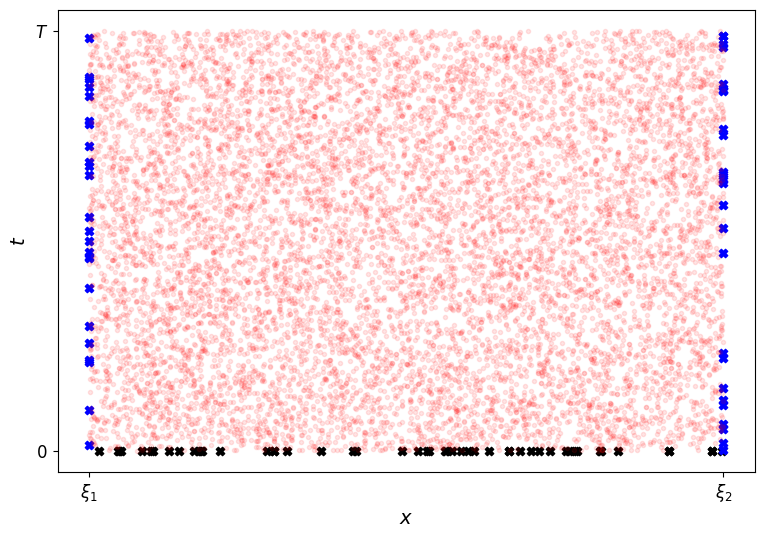

In [ ]:
x_f_np = x_f.numpy()
t_f_np = t_f.numpy()
x_0_np = x_0.numpy()
t_0_np = t_0.numpy()
x_b_np = x_b.numpy()
t_b_np = t_b.numpy()

fig = plt.figure(figsize=(9,6))
plt.scatter(x_0_np, t_0_np, c='black', marker='X', vmin=-1, vmax=1)
plt.scatter(x_b_np, t_b_np, c='blue', marker='X', vmin=-1, vmax=1)
plt.scatter(x_f_np, t_f_np, c='r', marker='.', alpha=0.1)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$t$', fontsize=14)

# Define os ticks do eixo x apenas no primeiro e último valor
plt.xticks([x_f_np.min(), x_f_np.max()], ['$\\xi_1$', '$\\xi_2$'], fontsize=12)

# Define os ticks do eixo y apenas no primeiro e último valor
plt.yticks([t_f_np.min(), t_f_np.max()], ['$0$', '$T$'], fontsize=12)

# plt.title('Posição dos pontos de colocação N_f (vermelho), dos dados iniciais N_0 (preto) e de fronteira N_b (azul)');
plt.savefig('nD_pontos_n0_pontos_nb_pontos.pdf', bbox_inches='tight', dpi=300)

<a name="p33"></a>
### 3.3. Configuração da rede neural

Neste exemplo, adaptado de ([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)), nós supomos uma rede neural feedforward com a seguinte estrutura:
- os dados de entrada estão escalonados ponto a ponto ao longo do intervalo $[-1,1]$ ou ao longo do quadrado $[-1,1] \times [-1,1]$

O motivo para fazer esse dimensionamento é tornar os valores de entrada adequados para a rede neural. Redes neurais tendem a funcionar melhor quando os valores estão em uma faixa próxima a 0, pois isso ajuda a controlar a propagação de gradientes durante o treinamento. Além disso, muitos algoritmos de otimização convergem de forma mais eficaz quando os valores estão nessa faixa.

No nosso caso, os dados são informados ao longo do retângulo $[-1,1] \times [0,1]$ o qual é transformado no quadrado $[-1,1] \times [-1,1]$ por meio da fórmula:

$$
\text{scaled_value} = 2 \cdot ((x,t) - lb) / (ub - lb) - 1
$$

onde a operação de divisão entre os vetores é feita ponto a ponto.

- temos uma rede neural de 9 camadas com 40 neurônios e a função de ativação em cada camada é a função de tangente hiperbólica

> o que acontece se trocarmos a função de ativação (testes para o futuro)?

- uma camada de saída

Esta configuração resulta em uma rede neural com $13281$ parâmetros a serem treinados (Ver ``model.summary()`` na seção [3.5](#p35)

### Escolha de (Camada, Neurônio) e iterações

- Testes realizados com o parâmetro loss para diversas duplas de (Neurônio, Camada) como sugerido por Blechschmidt, com $N_0=N_b=50$ e $N_f=10000$, além disso, utilizamos uma taxa de aprendizado via função por partes - **sem fixação da semente!**, queríamos saber como a rede oscilava e entender melhor como a inicialização de pesos e treinamento influenciava no loss e erro final.
- Região "ótima" encontrada
    - Testes com muita oscilação
    - Testes sem convergência
- Boxplot com melhores duplas
- Escolha da melhor combinação de (Neurônio, Camada)
- Escolha de $N_0,N_b$ e $N_f$

In [ ]:
def init_model(num_hidden_layers=9, num_neurons_per_layer=40):  # número de camadas ocultas = 9 / número de neuronios por camada = 40
    # Inicializa uma rede neural feedforward
    model = tf.keras.Sequential()

    # A entrada é bidimensional (uma dimensão espacial + tempo)
    model.add(tf.keras.Input(2))

    # Introduz uma camada de dimensionamento para mapear a entrada para [lb, ub] = [[-1,0], [1,1]] -- ajuste de escala para [-1,1] x [-1,1]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Anexa camadas ocultas
    '''
Camada Densa -> Camada totalmente conectada, cada neurônio na camada está conectado a todos os neurônios da camada anterior e da camada seguinte
Adicionamos uma camada densa a cada iteração (num_hidden_layers = 9 com num_neuron_per_layer = 40)
Função de ativação -> tanh (valores entre -1 e 1)
glorot_normal -> controle de fluxo de informações através da rede e melhorar a convergência durante o treinamento.
"garantir" que as ativações e os gradientes durante o treinamento não fiquem muito pequenos ou muito grandes.
O método ajusta a escala inicial dos pesos das camadas
        stddev = sqrt(2 / (fan_in + fan_out)) (https://rdrr.io/github/rstudio/keras/man/initializer_glorot_normal.html)
- fan_in é o número de unidades na camada de entrada (quantidade de conexões de entrada por neurônio).
- fan_out é o número de unidades na camada de saída (quantidade de conexões de saída por neurônio).
A ideia é que, quando a soma das entradas for muito maior do que a saída,
a escala será reduzida para evitar valores muito grandes que possam levar a instabilidades no treinamento.
Da mesma forma, se a soma das entradas for muito menor do que a saída, a escala será aumentada para evitar valores muito pequenos
Em resumo, o método Glorot Normal ajusta a escala inicial dos pesos das camadas da rede neural
com base nas dimensões das camadas de entrada e saída. Isso ajuda a controlar a propagação de valores
durante o treinamento e pode melhorar a convergência e o desempenho da rede.
    '''
    for _ in range(num_hidden_layers):  # _ é usado para representar uma variável que não é usada dentro do loop, serve apenas para iterar
# for i in range(num_hidden_layers) teria o mesmo resultado
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # A saída é unidimensional
    model.add(tf.keras.layers.Dense(1))

    return model

<a name="p34"></a>
### 3.4. Configuração das rotinas para derivação automática (automatic differentiation) e configuração da função de perda

Na célula abaixo, nós definimos uma função que avalia o resíduo

$$
f:= u_t + uu_x - \nu u_{xx}.
$$

da EDP não linear nos pontos $(x_i,t_i) \in (-1, 1) \times (0,1)$, $i = 1, \cdots, N_f$.

Para calcular as derivadas parciais nós usamos a diferenciação automática do TensorFlow.

Para a equação de Burgers, isto implica em calcular $\partial_t u_\theta$, $\partial_x u_\theta$ e $\partial_{xx} u_\theta$.

No TensorFlow, isto é feito via `GradientTape`, veja a [documentação](https://www.tensorflow.org/api_docs/python/tf/GradientTape), o que permanece rastreando as variáveis `watched`, no nosso caso `t` e `x`, a fim de calcular as derivadas.

In [ ]:
def get_r(model, XT_f):  # recebe um modelo e uma base de dados

    """(https://www.tensorflow.org/guide/autodiff?hl=pt-br#:~:text=to%20compute%20gradients.-,Gradient%20tapes,GradientTape%20onto%20a%20%22tape%22.)"""
    # Utiliza o tf.GradientTape para calcular derivadas no TensorFlow
    with tf.GradientTape(persistent=True) as tape:  # persistent=True permite fazer as segundas derivadas (reutiliza o mesmo GradientTape)
        # Divide t e x para calcular derivadas parciais
        x, t = XT_f[:, 0:1], XT_f[:,1:2]  # x é a primeira coluna de XT_f e t é a segunda coluna

        # Variáveis x e t são "marcadas" durante tape (para que o GradientTape acompanhe e calcule as derivadas em relação a essas variáveis)
        # para calcular as derivadas u_t e u_x
        tape.watch(x)
        tape.watch(t)

       # Determina a u
        u = model(tf.stack([x[:,0], t[:,0]], axis=1))  # utilizando o modelo e a u para calcular as derivadas

        # Calcula a derivada u_x dentro do tf.GradientTape
        # pois precisamos de segundas derivadas
        u_x = tape.gradient(u, x)
    #  Para calcular a derivada u_xx é necessário que u_x seja computado dentro deste ambiente.
    #  Por exemplo, se fosse necessário calcular u_tt, u_t deveria ser calculado dentro do ambiente.

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    # Libera o tape persistente para economizar recursos
    del tape

    # Retorna o resíduo calculado usando a função f fornecida
    return f(u, u_x, u_t, u_xx)

A próxima função calcula a função de perda do modelo

$$
\text{EMQ} = \text{EMQ}_f + \text{EMQ}_0 + \text{EMQ}_b
$$

como uma função dos nossos dados de treinamento.

In [ ]:
def compute_loss(model, XT_f, XT_data, u_data):

    # Calcula EMQ_f
    f = get_r(model, XT_f)
    EMQ_f = tf.reduce_mean(tf.square(f))

    # Inicializa a perda
    loss = EMQ_f

    # Adiciona EMQ_0 e EMQ_b à perda
    for i in range(len(XT_data)):
        u_pred = model(XT_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

    return loss

A próxima função calcula o gradiente da função de perda $\text{EMQ}$ com respeito as variáveis incógnitas do modelo, também chamadas de `trainable_variables` no TensorFlow, i.e. $\nabla \text{EMQ}$.

Isto também é feito via um `GradientTape`, mas agora ele permanece rastreando o parâmetro do nosso modelo, o qual pode ser acessado por `model.trainable_variables`.

In [ ]:
def get_grad(model, XT_f, XT_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # Esta tape é para derivadas em relação
        # às variáveis treináveis do modelo
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, XT_f, XT_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

<a name="p35"></a>
### 3.5 Treinamento da rede

Para inicializar o modelo é necessário definir a taxa de aprendizado. Em determinadas situações essa taxa pode ser definida por uma única constante, porém os experimentos realizados indicam que para uma melhor acurácia da solução numérica da EDP, é recomendável considerar uma taxa de aprendizado adaptável.

Nos seus experimentos numéricos Blechschmidt et.al. utilizam a taxa:

$$
\delta(n) = 0.01 \, \textbf{1}_{\{n < 1000\}} + 0.001 \, \textbf{1}_{\{1000 \le n < 3000\}} + 0.0005 \, \textbf{1}_{\{3000 \le n\}}
$$

o que decai de modo constante por partes, e configura um `tf.keras.optimizer` para treinar o modelo.

No nosso caso, utilizamos uma taxa de aprendizado que decai de modo constante partes com mais particionamentos. Essa taxa é definida como `lr` abaixo.

In [ ]:
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [100, 200, 500, 1000, 2000, 4000, 5000, 7000, 10000, 15000, 25000, 35000],
    [9e-3,7e-3, 5e-3, 3e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 5e-7,1e-7])

Na célula abaixo, definimos os parâmetros da rede e o otimizador utilizado para a minimização do $\text{EMQ}$.

In [ ]:
# Iniciamos o modelo u
model = init_model(num_hidden_layers=9, num_neurons_per_layer=40)

# Escolha do otmizador
optim = tf.keras.optimizers.Adam(learning_rate=lr)

#  Exibe um resumo da rede com informações sobre parâmetros
#  None indica que o modelo pode aceitar lotes de exemplos de qualquer tamanho durante o treinamento e inferência
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 40)                120       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 dense_3 (Dense)             (None, 40)                1640      
                                                                 
 dense_4 (Dense)             (None, 40)                1640      
                                                                 
 dense_5 (Dense)             (None, 40)                1

O treinamento do modelo para $N=5000$ épocas (leva aproximadamente 5 minutos).

Aqui, nós configuramos uma função `train_step()` que realiza um passo de treino.

*Nota*: A função `@tf.function` é chamada de `Decorator` dentro do Python. Este decorator particular redefine a função que segue, no nosso caso `train_step`, com um grafo TensorFlow que pode acelerar o treinamento significantemente.

In [ ]:
# Definição da função de um passo de treinamento como uma função do tf para aumentar a velocidade de treino
@tf.function  # adicionado no tensorflow 2.X, melhora o desempenho e tempo computacional significativamente
def train_step():
    loss, grad_theta = get_grad(model, XT_f, XT_data, u_data)

    # Realiza um passo do gradiente descendente
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Épocas
N = 1000
hist = []   # lista para armazenar os loss durante o treinamento

# Tempo inicial
t0 = time()

for i in range(N+1):

    loss = train_step()

    hist.append(loss.numpy())

    # Printa o loss a cada 100 iterações
    if i%100 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print tempo computacional
print('\nTempo computacional: {} segundos'.format(time()-t0))

It 00000: loss = 8.42141628e-01
It 00100: loss = 1.39385805e-01
It 00200: loss = 1.07956246e-01
It 00300: loss = 8.92730057e-02
It 00400: loss = 7.94673413e-02
It 00500: loss = 5.90214729e-02
It 00600: loss = 4.71278206e-02
It 00700: loss = 4.21691425e-02
It 00800: loss = 2.12000497e-02
It 00900: loss = 4.67410713e-01
It 01000: loss = 1.23079650e-01

Tempo computacional: 55.75488877296448 segundos


<a name="p36"></a>
### 3.6.    Visualização da solução

In [ ]:
# Carrega o arquivo .mat com a solução usada como referência
mat_data = scipy.io.loadmat('burgers_shock.mat')
usol = mat_data['usol']

usol.shape

(256, 100)

In [ ]:
# Gerando pontos atraves do lispace
# N = 500  # aumentar o valor para melhor visualização

# xspace = np.linspace(lb[1], ub[1], N + 1)
# tspace = np.linspace(lb[0], ub[0], N + 1)

# Utilizando pontos do mat_data
xspace = mat_data['x']  # espaço
tspace = mat_data['t']  # tempo

X, T = np.meshgrid(xspace, tspace)
grid = np.vstack([X.flatten(),T.flatten()]).T
'''
grid: é uma matriz bidimensional onde cada linha representa um ponto na malha 2D, com as coordenadas (x, t)
.flatten(): converte em um array 1D
[]: lista
vstack: "empilhamento" vertical
.T: transposto
'''
# Determina as predições de u(t, x) do nosso modelo
upred = model(tf.cast(grid, DTYPE))

# Transforma o U para o nosso formato
# U = upred.numpy().reshape(N+1,N+1)
U = upred.numpy().reshape(100,256)

# Crie uma figura com uma superfície 3D
fig = go.Figure(data=[go.Surface(x=X, y=T, z=U, colorscale='viridis')])

# Ajuste o layout
fig.update_layout(
    scene=dict(
        xaxis_title='$x$',
        yaxis_title='$t$',
        zaxis_title='$u(x,t)',
        xaxis=dict(nticks=10, range=[min(xspace), max(xspace)]),
        yaxis=dict(nticks=10, range=[min(tspace), max(tspace)]),
        zaxis=dict(range=[U.min(), U.max()])
    ),
    title='Solução predita da EDP',
    margin=dict(l=0, r=0, b=0, t=40),  # Ajuste de margem
    paper_bgcolor='lightgray',  # Cor de fundo
    scene_camera=dict(
        center=dict(x=0, y=0, z=0),  # Ajuste a posição da câmera
    ),
)

fig.show()

In [ ]:
# Cálculo do erro relativo
usol2 = usol.T   # necessário transpor usol
erro = LA.norm(U-usol2, 'fro') / LA.norm(usol2, 'fro')

# Use a notação exponencial para imprimir o valor
print("{:.8e}".format(erro))

In [ ]:
print(usol.shape, usol2.shape)
print(U.shape)

In [ ]:
import scipy.io as sio
# como salvar o arquivo predito em .mat
sio.savemat('melhor.mat', {'U':U, 'tspace_2':tspace_2, 'xspace_2': xspace_2})

In [ ]:
# Pontos
x = -1
t = 0.7

# Crie um array para a avaliação do modelo
ponto = np.array([[x, t]])

# Use o modelo treinado para fazer a previsão
predict = model(tf.cast(ponto, DTYPE))  # tf.cast para deixar o ponto no formato DTYPE

# O resultado da predição está em 'predict'
print("Predição em u(x, t):", predict.numpy()[0])  # [0] utilizado pois o retorno é uma lista com um elemento